In [1]:
import os
import numpy as np
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import kcu as utils
import time
import pandas as pd
from tpot import TPOTClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE
import seaborn as sns
from kcu import capsules
import torch.optim as optim
from tqdm import tqdm


""" SETUP """
dry_run = True
cwdir = os.getcwd()
trainfile = cwdir + "/../../data/MNIST/train.csv"
df = pd.read_csv(trainfile)

train_data = df.to_numpy()
train_Y = train_data[:, 0]
train_X = train_data[:, 1:]

# Split train set into train and validation
train_inds, val_inds = sklearn.model_selection.train_test_split(
    np.arange(len(train_Y)), test_size=0.2
)
train_X, val_X = train_X[train_inds], train_X[val_inds]
train_Y, val_Y = train_Y[train_inds], train_Y[val_inds]

if dry_run:
    train_X, train_Y = train_X[:1024], train_Y[:1024]

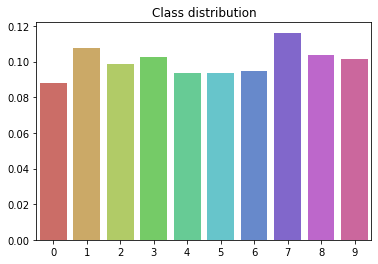

In [2]:
""" DATA EXPLORATION """
# Visualize class distribution
utils.visualization.show_class_distribution(train_Y)

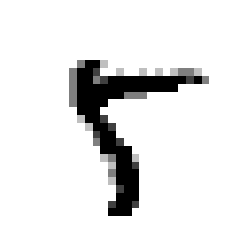

In [3]:
# As we know this is 2D image data, visualize some samples:
plt.imshow(train_X[0].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

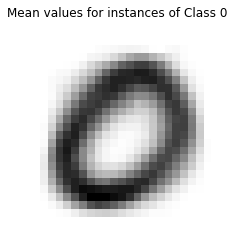

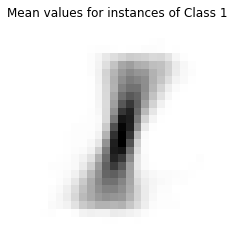

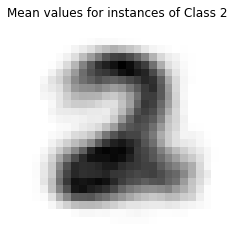

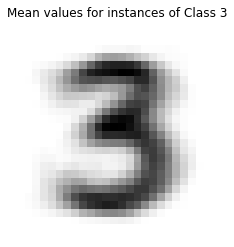

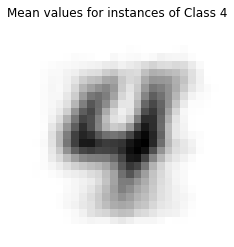

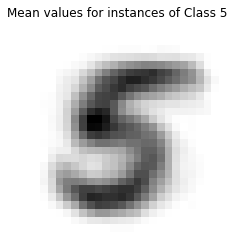

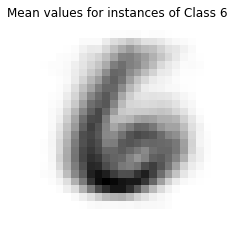

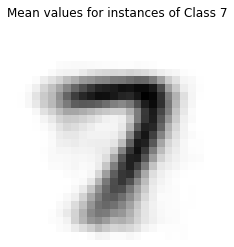

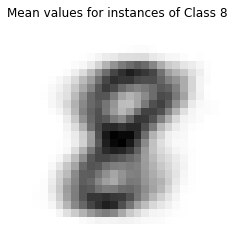

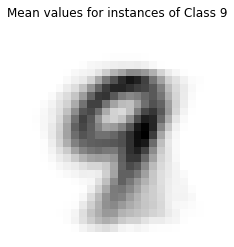

In [4]:
# Show an average of multiple instances from same class (class 1)
for i in range(10):
    inds = np.where(train_Y == i)
    acc = np.mean(train_X[inds], axis=0)
    plt.imshow(acc.reshape(28, 28), cmap="binary")
    plt.title("Mean values for instances of Class " + str(i))
    plt.axis("off")
    plt.show()

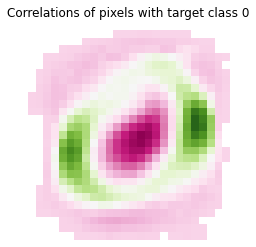

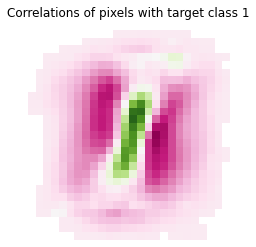

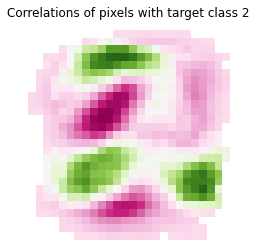

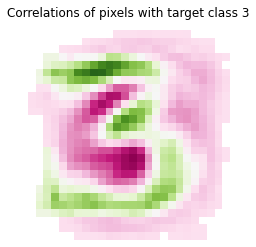

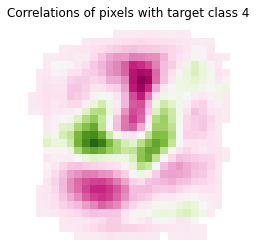

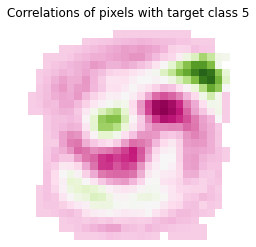

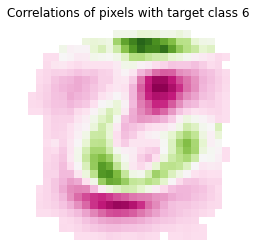

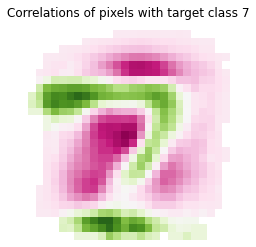

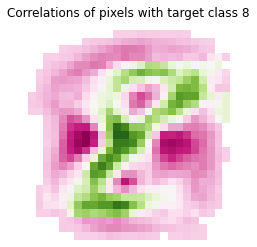

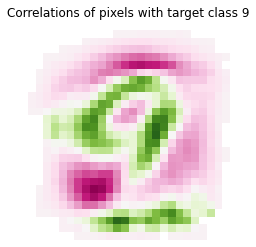

In [5]:
# Correlation analysis: for each class, lets identify important pixels first:
for i in range(10):
    new_Y = train_Y == i
    corr_coeff = pd.DataFrame(np.hstack([train_X, np.expand_dims(new_Y, 1)])).corr()[-1:].to_numpy()[0, :-1]
    plt.imshow(corr_coeff.reshape(28, 28), cmap="PiYG")
    plt.title("Correlations of pixels with target class " + str(i))
    plt.axis("off")
    plt.show()

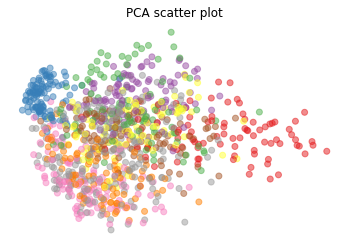

In [6]:
# Lets do PCA: identifying a good linear combination of features that maximize the total variance
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(train_X)
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap='Set1')
plt.axis("off")
plt.title("PCA scatter plot")
plt.show()

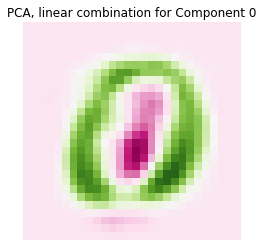

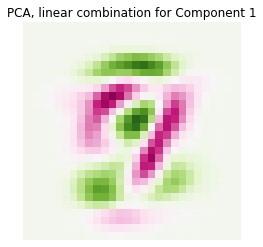

In [7]:
# Lets have a look at what features/pixels were used the most by our two PCA components:
for i in [0,1]:
    plt.imshow(pca.components_[i].reshape(28,28), cmap="PiYG")
    plt.title("PCA, linear combination for Component " + str(i))
    plt.axis("off")
    plt.show()

# There are a lot of pixels with no to only a bit of weight, so we could do feature selection and simply neglect pixels
# e.g. in the corners of the images

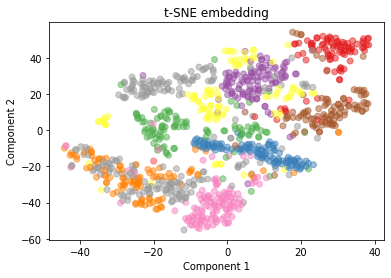

In [8]:
# Next, we visualize the t-SNE embedding. The desirable outcome here would be to have compact non-overlapping
# clusters of classes. This plot might already foreshadow - to some extent - how complicated the classification
# task will be
view = TSNE(n_components=2, random_state=0).fit_transform(train_X)
#plt.figure(figsize=(20,10))
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap="Set1")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("t-SNE embedding")
plt.show()

kNN scores:  [0.84878049 0.86829268 0.85365854 0.82439024 0.84803922]
SVM scores:  [0.88292683 0.85365854 0.87317073 0.88292683 0.87745098]


/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) re

MLP scores:  [0.76097561 0.77073171 0.8097561  0.75121951 0.82352941]
DecisionTree scores:  [0.65365854 0.69268293 0.6195122  0.57073171 0.62254902]
RandomForest scores:  [0.74146341 0.81463415 0.76097561 0.71219512 0.75      ]
AdaBoost scores:  [0.50243902 0.50243902 0.56585366 0.35121951 0.39215686]


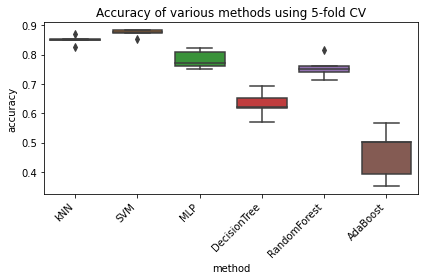

In [9]:
""" MAIN CLASSIFICATION PIPELINES """

# Try several classifiers using kFold CrossValidation
performances = utils.boilerplates.run_several_classifiers(train_X, train_Y, cv=True)

# Lets report their performances
chart = sns.boxplot(x="method", y="accuracy", data=performances)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Accuracy of various methods using 5-fold CV")
plt.tight_layout()
plt.show()

kNN scores:  [0.65384615 0.76923077 0.61538462 0.6        0.76      ]
SVM scores:  [0.73076923 0.88461538 0.69230769 0.76       0.88      ]
MLP scores:  [0.42307692 0.69230769 0.53846154 0.4        0.6       ]


/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) re

DecisionTree scores:  [0.5        0.5        0.57692308 0.36       0.48      ]
RandomForest scores:  [0.57692308 0.73076923 0.61538462 0.4        0.68      ]
AdaBoost scores:  [0.26923077 0.19230769 0.07692308 0.24       0.28      ]
kNN scores:  [0.78846154 0.68627451 0.74509804 0.68627451 0.74509804]
SVM scores:  [0.84615385 0.80392157 0.80392157 0.78431373 0.8627451 ]


/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) re

MLP scores:  [0.57692308 0.52941176 0.52941176 0.50980392 0.62745098]
DecisionTree scores:  [0.57692308 0.50980392 0.47058824 0.47058824 0.66666667]
RandomForest scores:  [0.65384615 0.62745098 0.62745098 0.64705882 0.66666667]
AdaBoost scores:  [0.30769231 0.23529412 0.21568627 0.21568627 0.35294118]
kNN scores:  [0.81553398 0.81553398 0.75490196 0.79411765 0.82352941]
SVM scores:  [0.89320388 0.83495146 0.81372549 0.85294118 0.85294118]


/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) re

MLP scores:  [0.70873786 0.7184466  0.66666667 0.60784314 0.65686275]
DecisionTree scores:  [0.63106796 0.5631068  0.58823529 0.62745098 0.62745098]
RandomForest scores:  [0.81553398 0.73786408 0.61764706 0.66666667 0.71568627]
AdaBoost scores:  [0.26213592 0.4368932  0.3627451  0.47058824 0.47058824]
kNN scores:  [0.84878049 0.86829268 0.85365854 0.82439024 0.84803922]
SVM scores:  [0.88292683 0.85365854 0.87317073 0.88292683 0.87745098]


/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) re

MLP scores:  [0.77560976 0.8        0.75121951 0.75609756 0.83333333]
DecisionTree scores:  [0.65365854 0.68780488 0.62926829 0.58536585 0.62254902]
RandomForest scores:  [0.74634146 0.77073171 0.77073171 0.76585366 0.70588235]
AdaBoost scores:  [0.50243902 0.50243902 0.56585366 0.35121951 0.39215686]


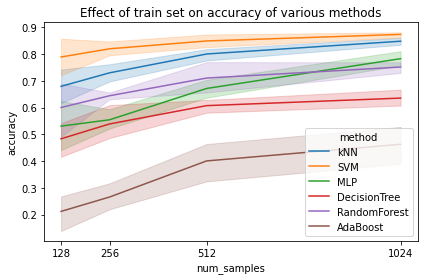

In [10]:
# Also, its interesting to see how well the classifiers do with less data
all_perfs = pd.DataFrame(columns=["method", "balanced_accuracy", "num_samples"])
possible_samples = [128, 256, 512, 1024]
for samples in possible_samples:
    performances = utils.boilerplates.run_several_classifiers(train_X[:samples], train_Y[:samples], cv=True)
    performances["num_samples"] = samples
    all_perfs = all_perfs.append(performances)

chart = sns.lineplot(x="num_samples", y="accuracy", hue="method", data=all_perfs)
#chart.set_xticklabels(possible_samples)
chart.set_xticks(possible_samples)
chart.set_xticklabels(possible_samples)
plt.title("Effect of train set on accuracy of various methods")
plt.tight_layout()
plt.show()

MLP Val accuracy: 0.7989285714285714


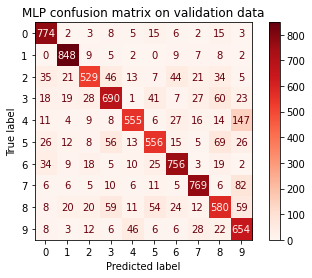

In [11]:
# Lets train an MLP (as they scale better than SVMs with the amount of training data)
clf = MLPClassifier()
clf.fit(train_X, train_Y)
pred = clf.predict(val_X)
score = sklearn.metrics.accuracy_score(val_Y, pred)
print("MLP Val accuracy: " + str(score))

# Plot confusion matrix of best classifier
sklearn.metrics.plot_confusion_matrix(clf,
                      val_X,
                      val_Y,
                      cmap="Reds")
plt.title("MLP confusion matrix on validation data")
plt.show()

Test Error: 
 Accuracy: 30.9%, Avg loss: 0.274523 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.223263 

Test Error: 
 Accuracy: 60.1%, Avg loss: 0.169948 

Test Error: 
 Accuracy: 66.2%, Avg loss: 0.138605 

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.120668 

Test Error: 
 Accuracy: 71.4%, Avg loss: 0.112453 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.100273 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.093681 

Test Error: 
 Accuracy: 79.2%, Avg loss: 0.084073 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.079722 

Test Error: 
 Accuracy: 82.6%, Avg loss: 0.073317 

Test Error: 
 Accuracy: 83.1%, Avg loss: 0.069216 

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.064945 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.060640 

Test Error: 
 Accuracy: 86.2%, Avg loss: 0.056555 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.057896 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.053965 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.055673 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.051206 

Test Error: 

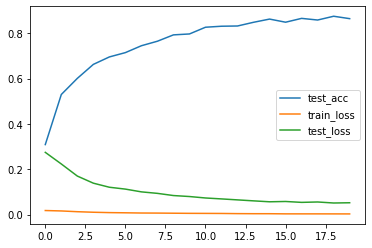

In [12]:
# Lets leverage the local spatial relations of the input data and use a 2D CNN
train_dataset = utils.dataset.MNISTDataset(train_X, train_Y)
val_dataset = utils.dataset.MNISTDataset(val_X, val_Y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = utils.models.MNIST_CNN_01().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
utils.boilerplates.train_classifier(
    cnn, optimizer, train_loader, device, 20, nn.CrossEntropyLoss(), val_loader, show_plot=True
)

In [16]:
# We could do some hyperparameter tuning now by doing GridSearch, however I rather want to check out
# one particular Neural Network that I worked with during my PhD: Capsule Networks
capsule_net = capsules.CapsuleNetwork().to(device)
criterion = capsules.CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

def train(capsule_net, criterion, optimizer, n_epochs=10, print_every=6):
    losses = []
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        capsule_net.train()
        for batch_i, (images, target) in tqdm(enumerate(train_loader)):
            target = torch.eye(10).index_select(dim=0, index=target)
            images, target = images.to(device), target.to(device)
            optimizer.zero_grad()
            caps_output, reconstructions, y = capsule_net(images)
            loss = criterion(caps_output, target, images, reconstructions)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0
        if epoch % 10 == 0:
            out = []
            gt = []
            capsule_net.eval()
            for image, target in tqdm(val_loader):
                image = image.to(device)
                caps_out, reconstructed, y = capsule_net(image)
                _, pred = torch.max(y.data.cpu(), 1)
                out.extend(pred.numpy().tolist())
                gt.extend(target.numpy().tolist())

            print("Capsule Network Accuracy:", sklearn.metrics.accuracy_score(gt, out))

    return losses

losses = train(capsule_net, criterion, optimizer, n_epochs=50)

/home/florian/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
8it [00:01,  4.86it/s]
0it [00:00, ?it/s]

Epoch: 1 	Training Loss: 1.91055860


8it [00:01,  5.10it/s]
0it [00:00, ?it/s]

Epoch: 2 	Training Loss: 1.68642557


8it [00:01,  5.28it/s]

Epoch: 3 	Training Loss: 1.42691636


8it [00:01,  5.26it/s]
8it [00:01,  5.27it/s]
0it [00:00, ?it/s]

Epoch: 4 	Training Loss: 1.35713667


8it [00:01,  5.49it/s]
0it [00:00, ?it/s]

Epoch: 5 	Training Loss: 1.32668281


8it [00:01,  5.42it/s]
0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 1.25964620


8it [00:01,  5.33it/s]
0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 1.19461638


8it [00:01,  5.53it/s]
0it [00:00, ?it/s]

Epoch: 8 	Training Loss: 1.13151697


8it [00:01,  5.06it/s]
0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 1.07873759


8it [00:01,  5.43it/s]
  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.03949701


100%|██████████| 1050/1050 [00:20<00:00, 51.48it/s]
1it [00:00,  5.23it/s]

Capsule Network Accuracy: 0.6860714285714286


8it [00:01,  5.11it/s]
0it [00:00, ?it/s]

Epoch: 11 	Training Loss: 0.98703618


8it [00:01,  5.48it/s]
0it [00:00, ?it/s]

Epoch: 12 	Training Loss: 0.95005519


8it [00:01,  5.12it/s]
0it [00:00, ?it/s]

Epoch: 13 	Training Loss: 0.91583754


8it [00:01,  5.33it/s]
0it [00:00, ?it/s]

Epoch: 14 	Training Loss: 0.89261938


8it [00:01,  5.10it/s]

Epoch: 15 	Training Loss: 0.85914571



8it [00:01,  5.17it/s]
0it [00:00, ?it/s]

Epoch: 16 	Training Loss: 0.82536945


8it [00:01,  5.42it/s]
0it [00:00, ?it/s]

Epoch: 17 	Training Loss: 0.79840531


8it [00:01,  5.14it/s]
0it [00:00, ?it/s]

Epoch: 18 	Training Loss: 0.76074338


8it [00:01,  5.38it/s]
0it [00:00, ?it/s]

Epoch: 19 	Training Loss: 0.74188241


8it [00:01,  5.28it/s]
  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.70419720


100%|██████████| 1050/1050 [00:20<00:00, 50.82it/s]
1it [00:00,  5.62it/s]

Capsule Network Accuracy: 0.8185714285714286


8it [00:01,  5.53it/s]
0it [00:00, ?it/s]

Epoch: 21 	Training Loss: 0.69079054


8it [00:01,  5.21it/s]
0it [00:00, ?it/s]

Epoch: 22 	Training Loss: 0.66300354


7it [00:01,  5.36it/s]

Epoch: 23 	Training Loss: 0.64955690


8it [00:01,  5.16it/s]
8it [00:01,  5.35it/s]
0it [00:00, ?it/s]

Epoch: 24 	Training Loss: 0.63301082


7it [00:01,  4.86it/s]

Epoch: 25 	Training Loss: 0.61549029


8it [00:01,  5.03it/s]
8it [00:01,  5.37it/s]
0it [00:00, ?it/s]

Epoch: 26 	Training Loss: 0.60387417


8it [00:01,  5.35it/s]
0it [00:00, ?it/s]

Epoch: 27 	Training Loss: 0.59133756


8it [00:01,  5.32it/s]
0it [00:00, ?it/s]

Epoch: 28 	Training Loss: 0.58731229


8it [00:01,  5.08it/s]
0it [00:00, ?it/s]

Epoch: 29 	Training Loss: 0.56676879


8it [00:01,  5.02it/s]

Epoch: 30 	Training Loss: 0.55205330


8it [00:01,  5.02it/s]
100%|██████████| 1050/1050 [00:20<00:00, 51.22it/s]
0it [00:00, ?it/s]

Capsule Network Accuracy: 0.8564285714285714


8it [00:01,  5.47it/s]
0it [00:00, ?it/s]

Epoch: 31 	Training Loss: 0.54963483


8it [00:01,  5.20it/s]
0it [00:00, ?it/s]

Epoch: 32 	Training Loss: 0.53957838


8it [00:01,  5.44it/s]
0it [00:00, ?it/s]

Epoch: 33 	Training Loss: 0.52701757


8it [00:01,  5.13it/s]
0it [00:00, ?it/s]

Epoch: 34 	Training Loss: 0.51436636


8it [00:01,  5.34it/s]
0it [00:00, ?it/s]

Epoch: 35 	Training Loss: 0.51582402


8it [00:01,  5.32it/s]
0it [00:00, ?it/s]

Epoch: 36 	Training Loss: 0.51204083


8it [00:01,  5.39it/s]
0it [00:00, ?it/s]

Epoch: 37 	Training Loss: 0.49764586


8it [00:01,  5.35it/s]
0it [00:00, ?it/s]

Epoch: 38 	Training Loss: 0.49896914


8it [00:01,  5.13it/s]
0it [00:00, ?it/s]

Epoch: 39 	Training Loss: 0.49925313


8it [00:01,  5.31it/s]
  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.49155166


100%|██████████| 1050/1050 [00:20<00:00, 50.69it/s]
1it [00:00,  5.63it/s]

Capsule Network Accuracy: 0.8633333333333333


8it [00:01,  5.38it/s]
0it [00:00, ?it/s]

Epoch: 41 	Training Loss: 0.48811007


8it [00:01,  5.11it/s]
0it [00:00, ?it/s]

Epoch: 42 	Training Loss: 0.49264967


8it [00:01,  5.26it/s]
0it [00:00, ?it/s]

Epoch: 43 	Training Loss: 0.46779478


7it [00:01,  5.47it/s]

Epoch: 44 	Training Loss: 0.47211032


8it [00:01,  5.40it/s]
8it [00:01,  5.13it/s]
0it [00:00, ?it/s]

Epoch: 45 	Training Loss: 0.46375181


8it [00:01,  5.29it/s]
0it [00:00, ?it/s]

Epoch: 46 	Training Loss: 0.46634361


8it [00:01,  5.37it/s]
0it [00:00, ?it/s]

Epoch: 47 	Training Loss: 0.46743593


7it [00:01,  5.29it/s]

Epoch: 48 	Training Loss: 0.47017581


8it [00:01,  5.19it/s]
8it [00:01,  5.26it/s]

Epoch: 49 	Training Loss: 0.45606879


'\nout = []\ngt = []\ncapsule_net.eval()\nfor image, target in tqdm(val_loader):\n    image = image.to(device)\n    caps_out, reconstructed, y = capsule_net(image)\n    _, pred = torch.max(y.data.cpu(), 1)\n    out.extend(pred.numpy().tolist())\n    gt.extend(target.numpy().tolist())\n\nprint("Capsule Network Accuracy:", sklearn.metrics.accuracy_score(gt, out))\n'